In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
data_path = os.path.join("/", "data", "km3net")

In [3]:
reco_path = os.path.join(data_path, "reco_files_fitinf")

In [4]:
multi_data_path = os.path.join(data_path, "Xy_multi_data_files")

In [5]:
numu_filep = "km3_v4_numuCC_{}.evt.reco_fitinf.npz"

In [6]:
reco_files_fitinf_numu = [os.path.join(reco_path, numu_filep.format(i + 1)) for i in range(100)]

In [7]:
from data_files import get_multi_data_files, get_doms_maps

In [8]:
true_data = get_multi_data_files(multi_data_path, merge=False, n_files=100)[0]

In [9]:
np.load(true_data[0]).keys()

['E', 'dirz', 'diry', 'dirx', 'posz', 'posx', 'posy', 'y', 'x', 'dist']

In [10]:
doms_map_files_numu = get_doms_maps(multi_data_path, merge=False, n_files=100)[0]

In [11]:
doms_map_files_numu[0]

'/data/km3net/Xy_multi_data_files/numu_1_sel5_doms_map.npz'

In [12]:
lik = [np.load(reco_files_fitinf_numu[i])["lik"][np.load(doms_map_files_numu[i])["id"]] for i in range(100)]
beta = [np.load(reco_files_fitinf_numu[i])["beta0"][np.load(doms_map_files_numu[i])["id"]] for i in range(100)]

In [13]:
lik[0].shape

(1472,)

In [14]:
beta[0].shape

(1472,)

In [15]:
reco_numu_E = [np.load(reco_files_fitinf_numu[i])["dirz"] for i in range(100)] 

In [16]:
true_numu_E = [np.load(true_data[i])["dirz"] for i in range(100)]

In [17]:
reco_numu_E[0].shape

(1545,)

In [18]:
true_numu_E[0].shape

(1472,)

In [19]:
reco_numu_E_5doms = [reco_numu_E[i][np.load(doms_map_files_numu[i])["id"]] for i in range(100)]

In [20]:
nonzero = [np.where(reco_numu_E_5doms[i]!=0) for i in range(100)]

In [21]:
reco_numu_E_5doms[0].shape

(1472,)

In [22]:
reco_numu_E_nonzero = [reco_numu_E_5doms[i][nonzero[i]] for i in range(100)]

In [23]:
reco_numu_E_nonzero[0].shape

(1456,)

In [24]:
true_numu_E_nonzero = [true_numu_E[i][nonzero[i]] for i in range(100)]

In [88]:
best_reco_indices = [np.where(np.logical_and(lik[i]<-0, np.log10(beta[i])<-2.8 ))[0] for i in range(100)]

/home/cdesio/anaconda3/envs/intel/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [89]:
best_reco_indices[0].shape

(704,)

In [90]:
best_reco_E = [reco_numu_E_5doms[i][best_reco_indices[i]] for i in range(100)]

In [91]:
best_true_numu_E = [true_numu_E[i][best_reco_indices[i]] for i in range(100)]

In [92]:
best_reco_E[0].shape

(704,)

In [93]:
best_true_numu_E[0].shape

(704,)

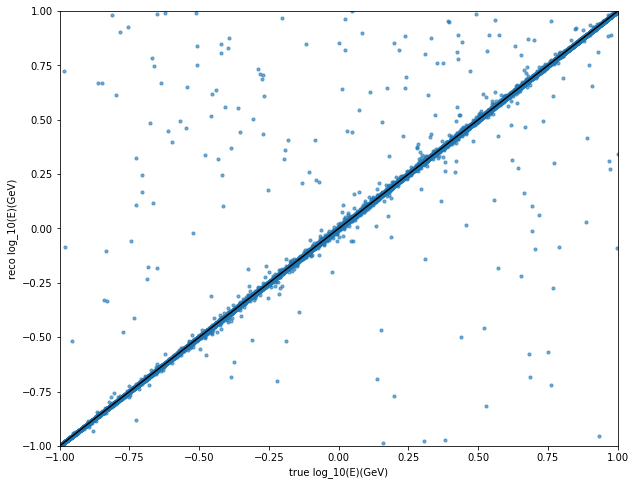

In [94]:
plt.figure(figsize=(10,8))
plt.scatter(np.hstack(best_true_numu_E), np.hstack(best_reco_E),
            alpha=0.6,s=10)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot([-1,1], [-1,1], c="k")
plt.xlabel("true log_10(E)(GeV)")
plt.ylabel("reco log_10(E)(GeV)")
plt.show()

In [154]:
true_E = np.hstack(true_numu_E)
reco_E = np.hstack(reco_numu_E_5doms)

In [59]:
true_E = np.hstack(true_numu_E_nonzero)
reco_E = np.hstack(reco_numu_E_nonzero)

In [31]:
true_E.shape

(149706,)

In [95]:
true_E = np.hstack(best_true_numu_E)

In [96]:
reco_E = np.hstack(best_reco_E)

In [97]:
true_E.shape

(71241,)

In [98]:
from sklearn.metrics import mean_squared_error, r2_score

In [99]:
print(mean_squared_error(true_E, reco_E))
print(r2_score(true_E, reco_E))


0.00164857827761
0.993787587846


In [100]:
def process_cosz(y):
    y_p = np.copy(y)
    y_p[y_p>0] = 1
    y_p[y_p<=0] = 0
    return y_p

In [74]:
true_E_lab = process_cosz(true_E)

In [75]:
reco_E_lab = process_cosz(reco_E)

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [78]:
accuracy_score(true_E_lab, reco_E_lab)

0.99806291321008966

In [101]:
en_true_reco = [(et, er) for et,er in zip(true_E, reco_E)]
en_reco_true = [(er, et) for et,er in zip(true_E, reco_E)]

#en_true_reco_corr = [(np.log10(et), np.log10(er)) for et,er in zip(true_E, corr_reco_E) if er > 0]
#en_reco_true_corr = [(np.log10(er), np.log10(et)) for et,er in zip(true_E, corr_reco_E) if er > 0]

In [102]:
def binbounds(lsval, binmin, binmax, clev):
    odata = [(x[1]-x[0]) for x in lsval if binmin <= x[0] < binmax]
    excluded = int(np.floor((1.0 - clev) * len(odata) * 0.5))
    odata.sort()    
    return (0.5*(binmax+binmin),odata[excluded],odata[-excluded])

In [103]:
def plot_performances(values_list, range_ext_1, range_ext_2, coeff = 0.5,  xlabel="True log(Energy(GeV))", ylabel="Predicted log(Energy(GeV))"):
    plt.figure(figsize=(9,7))
    cl_68_nn = [binbounds(values_list,x*coeff,(x+1)*coeff,0.68) for x in range(range_ext_1,range_ext_2)]
    cl_90_nn = [binbounds(values_list,x*coeff,(x+1)*coeff,0.90) for x in range(range_ext_1,range_ext_2)]
    median_nn = [binbounds(values_list,x*coeff,(x+1)*coeff,0) for x in range(range_ext_1,range_ext_2)]

    line_68_1 = plt.plot([x[0] for x in cl_68_nn],[x[1]+x[0] for x in cl_68_nn],"steelblue", label="68% confidence level", alpha=1)
    line_68_2 = plt.plot([x[0] for x in cl_68_nn],[x[2]+x[0] for x in cl_68_nn],"steelblue", alpha=1)
    line_90_1 = plt.plot([x[0] for x in cl_90_nn],[x[1]+x[0] for x in cl_90_nn],"lightslategray", label="90% confidence level",alpha=1)
    line_90_2 = plt.plot([x[0] for x in cl_90_nn],[x[2]+x[0] for x in cl_90_nn],"lightslategray",alpha=1)
    median = plt.plot([x[0] for x in median_nn],[x[2]+x[0] for x in median_nn],"k", label="median")
    regr_line = plt.plot([-1,1],[-1,1],"r", label='true', lw=1)

    plt.fill_between([x[0] for x in cl_68_nn], [x[1]+x[0] for x in cl_68_nn], [x[2]+x[0] for x in cl_68_nn],
                color='cornflowerblue',alpha=0.7)
    plt.fill_between([x[0] for x in cl_90_nn], [x[1]+x[0] for x in cl_90_nn], [x[2]+x[0] for x in cl_90_nn],
                color='lightsteelblue',alpha=0.7)


    #plt.scatter([x[0] for x in values_list], [x[1] for x in values_list], s=1, 
    #            marker='o', color='black', edgecolor='k', alpha=0.2)
    plt.minorticks_on()
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.legend(loc="lower right")
    plt.grid(b=True, which='both', color='0.65', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return

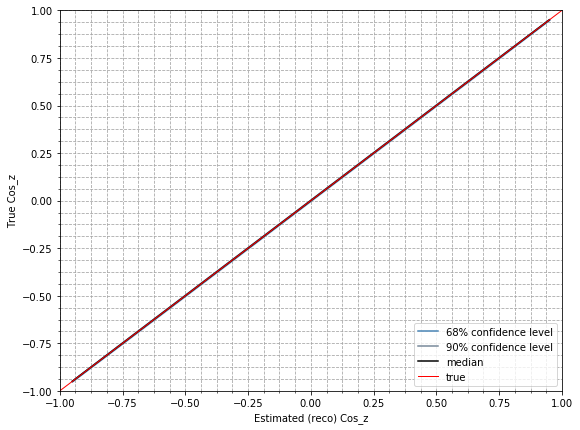

In [104]:
plot_performances(en_true_reco, -10,10, coeff=0.1, xlabel="Estimated (reco) Cos_z", ylabel="True Cos_z")

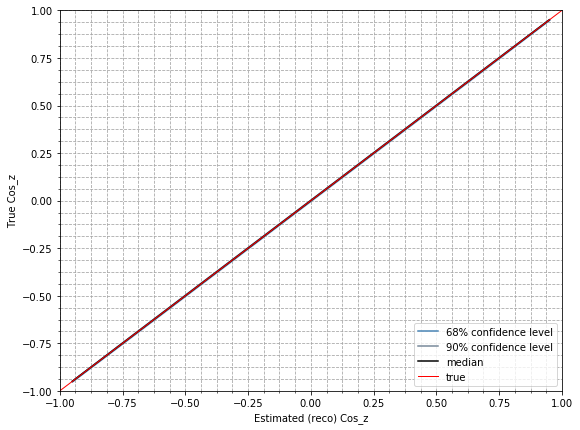

In [105]:
plot_performances(en_reco_true, -10,10, coeff=0.1, 
                  xlabel="Estimated (reco) Cos_z", ylabel="True Cos_z")

### now let's check the NN performances on the best_events

In [106]:
import keras
import keras.backend as K

In [107]:
def get_TZ_data(X):
    TZ = np.sum(X, axis=(2, 3))
    if K.image_data_format() == "channels_first":
        TZ = TZ[:, np.newaxis, ...]
    else:
        TZ = TZ[..., np.newaxis]
    return [TZ]

In [108]:
# %load data_loaders
from math import ceil
import numpy as np
import pandas as pd
from collections import OrderedDict
from keras.engine.topology import _to_list
from keras.utils import to_categorical
from numpy import concatenate as concat
from sklearn.utils.class_weight import compute_class_weight
from export_train_test import (INDEX_TRAINING_KEY, INDEX_TEST_KEY, INDEX_VALIDATION_KEY)


def data_generator(fnames, indices_list, batch_size=64, fdata=lambda X: X, ftarget=lambda y: to_categorical(y)):

    while True:
        file_idx = 0
        X_buff = Y_buff = None
        residual = False
        while file_idx < len(fnames):
            fname = fnames[file_idx]
            Xy = np.load(fname)
            X, y = Xy['x'], Xy['dirz']
            X_best = X[indices_list[file_idx]]
            Y = ftarget(y[indices_list[file_idx]])
            X = _to_list(fdata(X_best))  # X will be finally a list
            idx = 0  # batch current file
            while idx < Y.shape[0]:
                if residual:  # i.e. there are samples stored from previous iteration
                    incr = (batch_size - X_buff[0].shape[0])
                else:
                    incr = batch_size

                start, end = idx, idx + incr

                if end > Y.shape[0]:  # current file is completed
                    if X_buff is None:
                        X_buff, Y_buff = [X_in[start:] for X_in in X], Y[start:]
                    else:
                        X_buff = [concat((X_in_buff, X_in[start:])) for X_in_buff, X_in in zip(X_buff, X)]
                        Y_buff = concat((Y_buff, Y[start:]))
                    residual = True
                    break
                X_batch, Y_batch = [X_in[start:end] for X_in in X], Y[start:end]
                if residual:
                    X_batch = [concat((X_in_buff, X_in_batch)) for X_in_buff, X_in_batch in zip(X_buff, X_batch)]
                    Y_batch = concat((Y_buff, Y_batch))
                else:
                    X_buff = Y_buff = None

                yield X_batch, Y_batch
                idx += incr
                residual = False
            file_idx += 1
        else:
            if residual:
                yield X_buff, Y_buff


In [109]:
numu_gen = data_generator(true_data, indices_list=best_reco_indices, batch_size=64, fdata=get_TZ_data , ftarget=lambda y: y)

In [110]:
# %load data_loaders
from math import ceil
import numpy as np
import pandas as pd
from collections import OrderedDict
from keras.engine.topology import _to_list
from keras.utils import to_categorical
from numpy import concatenate as concat
from sklearn.utils.class_weight import compute_class_weight
from export_train_test import (INDEX_TRAINING_KEY, INDEX_TEST_KEY, INDEX_VALIDATION_KEY)


def get_n_iterations(fnames_list, indices_list, target_key="y", batch_size=64):
    """
    Function to get the number of iterations required to
    process the total set of samples extracted from the list
    of data files in input.

    Parameters
    ----------
    fnames_list: list
        List of data files to read from. Expected file format is Numpy/Compressed
        as created from `numpy.savez_compressed`.

    target_key: str (default "y")
        The key in the file to be used to calculate the number of samples

    batch_size: int (default 64)
        The size of the batch that is expected to be used in the training process.

    Returns
    -------
        int, int: total number of iterations and total number of events
        extracted from list of input files.
    """
    tot_events = 0
    for i, fil in enumerate(fnames_list):
        yf = np.load(fil)[target_key]
        ybest = yf[indices_list[i]]
        yf=ybest
        tot_events += yf.shape[0]
    iterations = int(ceil(tot_events / float(batch_size)))
    return iterations, tot_events


In [111]:
predict_steps, tot_test_events = get_n_iterations(true_data, best_reco_indices, "dirz", batch_size=64)
print(predict_steps, tot_test_events)

1114 71241


In [112]:
from tqdm import tqdm

In [113]:
from network_models import TZnet_regression_cosz

In [114]:
model = TZnet_regression_cosz()
model.load_weights('./model_no_git/tz_net_regression_64_100_regression_cosz.hdf5')

In [115]:
from keras import backend as K
from keras.utils import to_categorical

In [116]:
y_true = list()
y_pred = list()
for _ in tqdm(range(predict_steps)):
    X_batch, Y_batch_true = next(numu_gen)
    Y_batch_pred = model.predict_on_batch(X_batch)
    y_true.append(Y_batch_true)
    y_pred.append(Y_batch_pred.ravel())

y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))

100%|██████████| 1114/1114 [07:16<00:00,  2.55it/s]


In [117]:
y_true.shape

(71241,)

In [118]:
mean_squared_error(y_true, y_pred)

0.0025354410504981758

In [119]:
r2_score(y_true, y_pred)

0.99044558271057004

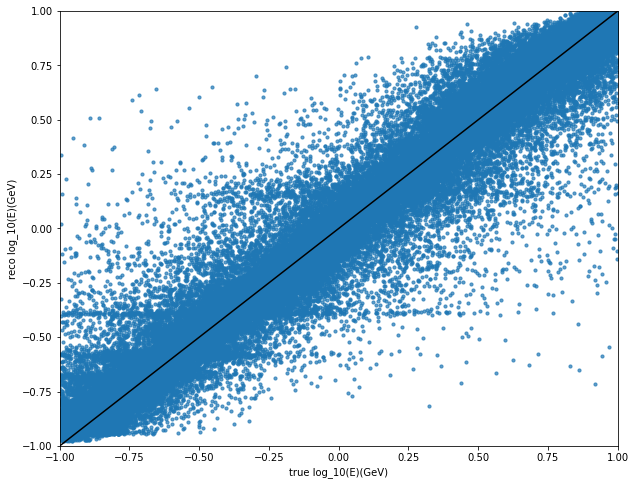

In [87]:
plt.figure(figsize=(10,8))
plt.scatter(y_true, y_pred,
            alpha=0.7,s=10)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot([-1,1], [-1,1], c="k")
plt.xlabel("true log_10(E)(GeV)")
plt.ylabel("reco log_10(E)(GeV)")
plt.show()

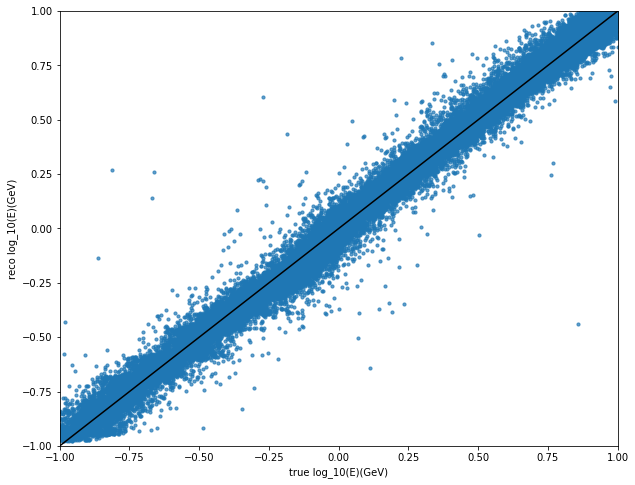

In [120]:
plt.figure(figsize=(10,8))
plt.scatter(y_true, y_pred,
            alpha=0.7,s=10)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot([-1,1], [-1,1], c="k")
plt.xlabel("true log_10(E)(GeV)")
plt.ylabel("reco log_10(E)(GeV)")
plt.show()

In [66]:
en_true_nn = [(et, en) for et,en in zip(y_true, y_pred)]
en_nn_true = [(en, et) for et, en in zip(y_true, y_pred) ]

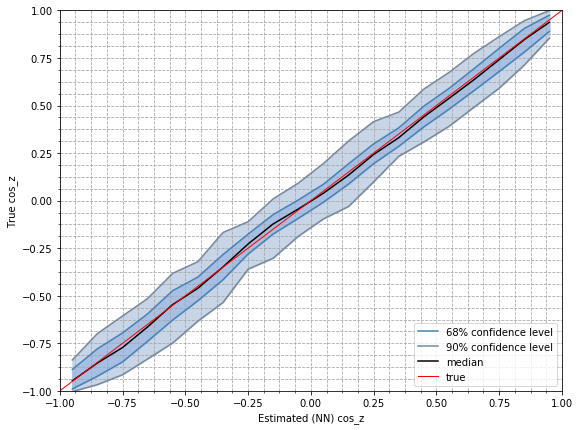

In [69]:
plot_performances(en_nn_true, -10, 10, coeff=0.1, 
                  xlabel="Estimated (NN) cos_z", 
                  ylabel="True cos_z")

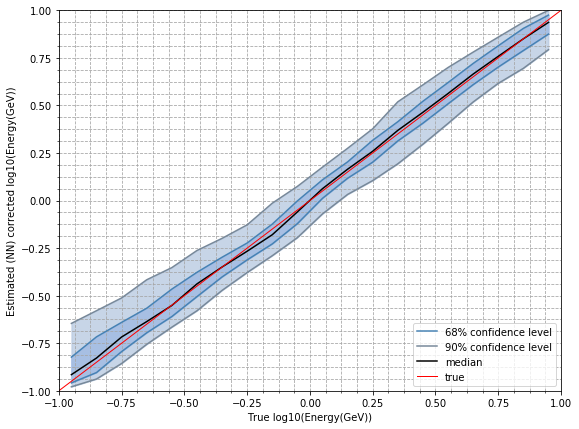

In [68]:
plot_performances(en_true_nn, -10, 10, coeff=0.1, 
                  ylabel="Estimated (NN) corrected log10(Energy(GeV))", 
                  xlabel="True log10(Energy(GeV))")

In [72]:
print(mean_squared_error(y_true, y_pred))
print(r2_score(y_true, y_pred))

0.0025354410505
0.990445582711


In [54]:
np.hstack(best_true_numu_E)[:10]

array([ 0.208183, -0.020776, -0.548133, -0.098729, -0.011285,  0.640216,
        0.927204,  0.305527,  0.083693,  0.020848])

In [55]:
y_true[:10]

array([ 2.44734877,  2.42958273,  2.66930758,  2.53459337,  2.59308106,
        2.48131074,  2.67410575,  3.02270874,  2.53257222,  3.00327954])

In [79]:
from network_models import TZ_updown_classification

In [80]:
model = TZ_updown_classification(2)

In [81]:
vgg_tz_net = keras.models.load_model("models/vgg_tz_updown_cosz_cls_weighted_100files_64_12x12_100epochs.hdf5")

In [116]:
# %load data_loaders
from math import ceil
import numpy as np
import pandas as pd
from collections import OrderedDict
from keras.engine.topology import _to_list
from keras.utils import to_categorical
from numpy import concatenate as concat
from sklearn.utils.class_weight import compute_class_weight
from export_train_test import (INDEX_TRAINING_KEY, INDEX_TEST_KEY, INDEX_VALIDATION_KEY)


def data_generator(fnames, indices_list, batch_size=64, fdata=lambda X: X, ftarget=lambda y: to_categorical(y)):

    while True:
        file_idx = 0
        X_buff = Y_buff = None
        residual = False
        while file_idx < len(fnames):
            fname = fnames[file_idx]
            Xy = np.load(fname)
            X, y = Xy['x'], Xy['dirz']
            X_best = X[indices_list[file_idx]]
            Y = ftarget(y[indices_list[file_idx]])
            X = _to_list(fdata(X_best))  # X will be finally a list
            idx = 0  # batch current file
            while idx < Y.shape[0]:
                if residual:  # i.e. there are samples stored from previous iteration
                    incr = (batch_size - X_buff[0].shape[0])
                else:
                    incr = batch_size

                start, end = idx, idx + incr

                if end > Y.shape[0]:  # current file is completed
                    if X_buff is None:
                        X_buff, Y_buff = [X_in[start:] for X_in in X], Y[start:]
                    else:
                        X_buff = [concat((X_in_buff, X_in[start:])) for X_in_buff, X_in in zip(X_buff, X)]
                        Y_buff = concat((Y_buff, Y[start:]))
                    residual = True
                    break
                X_batch, Y_batch = [X_in[start:end] for X_in in X], Y[start:end]
                if residual:
                    X_batch = [concat((X_in_buff, X_in_batch)) for X_in_buff, X_in_batch in zip(X_buff, X_batch)]
                    Y_batch = concat((Y_buff, Y_batch))
                else:
                    X_buff = Y_buff = None

                yield X_batch, Y_batch
                idx += incr
                residual = False
            file_idx += 1
        else:
            if residual:
                yield X_buff, Y_buff



In [114]:
def get_TZ_data(X):
    TZ = np.sum(X, axis=(2, 3))
    TZ = TZ[:, np.newaxis, ...]
    return [TZ]
def process_cos_Z(y):
    y[y>0]=1
    y[y<=0]=0
    return to_categorical(y)

In [117]:
numu_gen = data_generator(true_data, indices_list=best_reco_indices, batch_size=64, fdata=get_TZ_data, 
                          ftarget=process_cos_Z)

In [118]:
y_true_upd = list()
y_pred_upd = list()
y_probs = None
for _ in tqdm(range(predict_steps)):
    X_batch, Y_batch_true = next(numu_gen)
    Y_batch_pred = vgg_tz_net.predict_on_batch(X_batch)
    if y_probs is None:
        y_probs = Y_batch_pred
    else:
        y_probs = np.vstack((y_probs, Y_batch_pred))

    y_true_upd.append(np.argmax(Y_batch_true, axis=1))
    y_pred_upd.append(np.argmax(Y_batch_pred, axis=1))

y_true_upd = np.hstack(np.asarray(y_true_upd))
y_pred_upd = np.hstack(np.asarray(y_pred_upd))

100%|██████████| 1114/1114 [07:04<00:00,  2.63it/s]


In [119]:
y_pred_upd

array([1, 0, 0, ..., 0, 0, 1])

In [120]:
accuracy_score(y_true_upd, y_pred_upd)

0.98708608806726461

In [121]:
from sklearn.metrics import confusion_matrix

In [122]:
confusion_matrix(y_true_upd, y_pred_upd)

array([[29965,   480],
       [  440, 40356]])